In [26]:
import h5py
import numpy as np
import random
from sklearn.metrics import silhouette_score, v_measure_score
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sknetwork.clustering import Louvain
import matplotlib.pyplot as plt


# Load Data Content
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')

data_content = {
    'pge': pge_content,
    'resnet50': resnet50_content,
    'inceptionv3': inceptionv3_content,
    'vgg16': vgg16_content
}

In [27]:
# Constants
feature_types = ['pca', 'umap']
representations = ['pge', 'resnet50', 'inceptionv3', 'vgg16']
modularity_options = ['Dugue', 'Newman', 'Potts']
random_state = 0
results_headers = dict({'Metrics': ['count', 'silhouette', 'V-measure']})


# Prepare Datasets
datasets = {representation: {feature: data_content[representation]['pca_feature'][...] for feature in feature_types} for representation in representations}
best_cluster_sizes = {}
best_scores = {}
scores_silhouette = []
scores_v_measure = []
cluster = []
print(f"Available representations: {representations}")


Available representations: ['pge', 'resnet50', 'inceptionv3', 'vgg16']


Available representations: ['pge', 'resnet50', 'inceptionv3', 'vgg16']


The choosen representation is:  pge


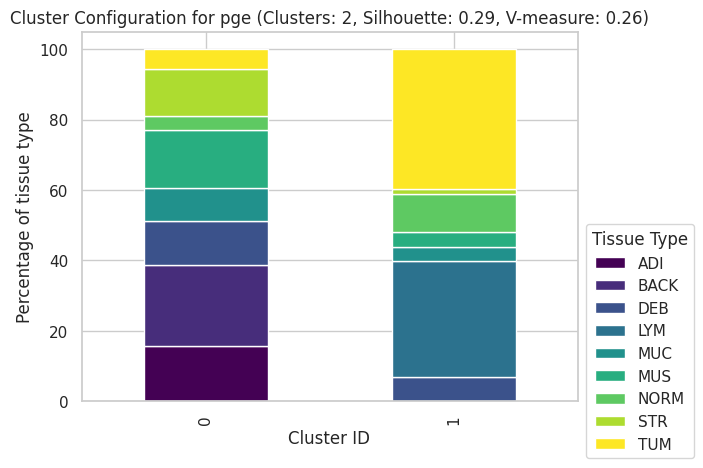

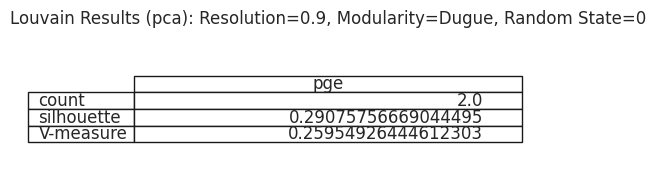

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.29075756669044495
V-measure Score: 0.25954926444612303

Modularity: Newman
Error in: (pca): Resolution=0.9, Modularity=Newman, Random State=0
list index out of range


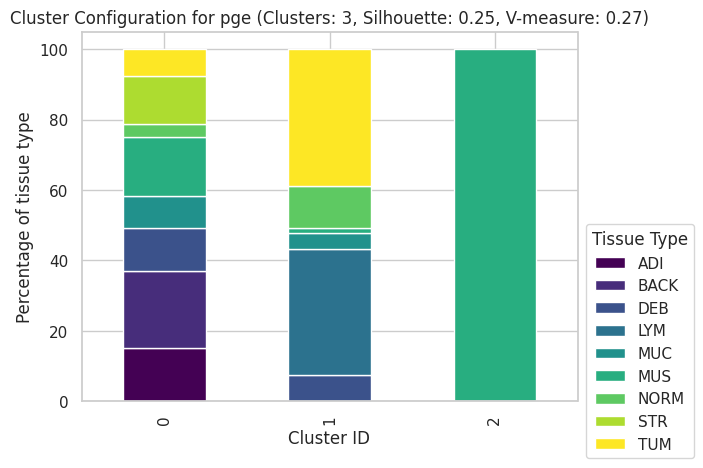

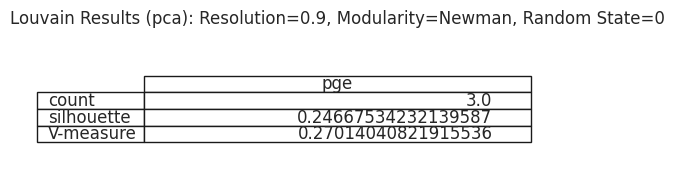

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.29075756669044495
V-measure Score: 0.25954926444612303

Modularity: Newman
Cluster Size: 3
Silhouette Score: 0.24667534232139587
V-measure Score: 0.27014040821915536

Modularity: Potts
Error in: (pca): Resolution=0.9, Modularity=Potts, Random State=0
list index out of range


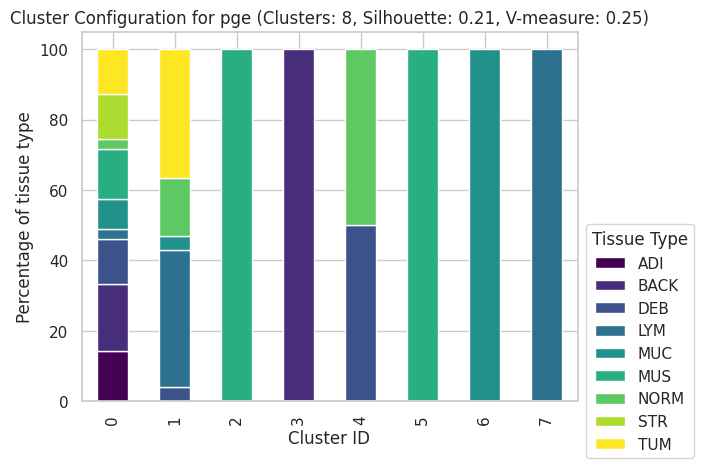

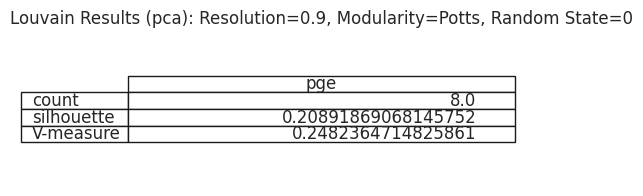

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.29075756669044495
V-measure Score: 0.25954926444612303

Modularity: Newman
Cluster Size: 3
Silhouette Score: 0.24667534232139587
V-measure Score: 0.27014040821915536

Modularity: Potts
Cluster Size: 8
Silhouette Score: 0.20891869068145752
V-measure Score: 0.2482364714825861



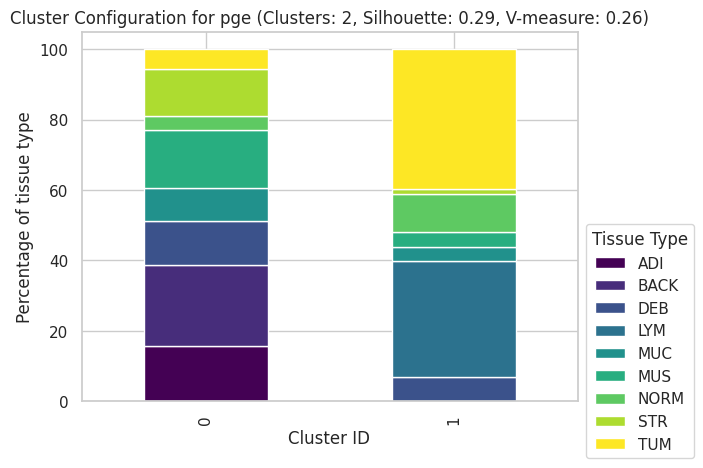

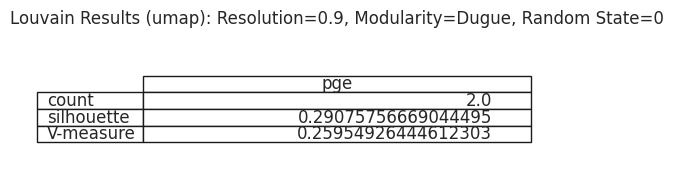

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.29075756669044495
V-measure Score: 0.25954926444612303

Modularity: Newman
Error in: (umap): Resolution=0.9, Modularity=Newman, Random State=0
list index out of range


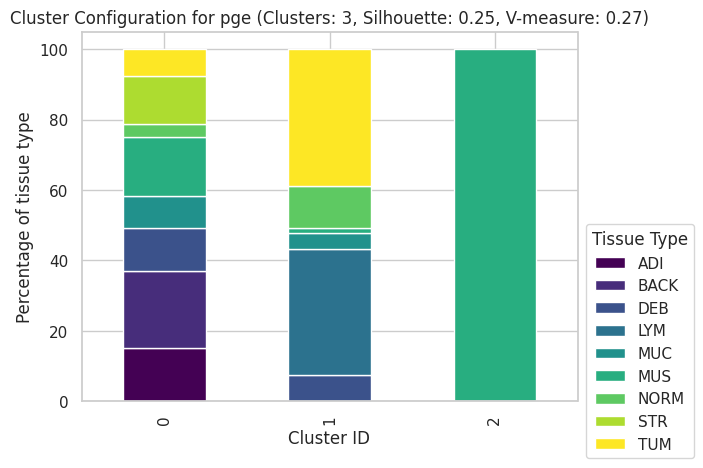

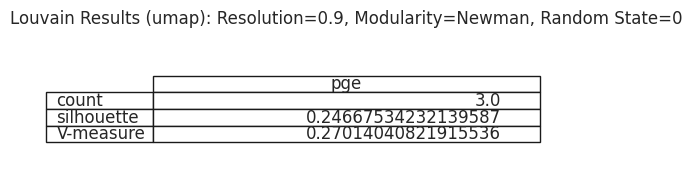

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.29075756669044495
V-measure Score: 0.25954926444612303

Modularity: Newman
Cluster Size: 3
Silhouette Score: 0.24667534232139587
V-measure Score: 0.27014040821915536

Modularity: Potts
Error in: (umap): Resolution=0.9, Modularity=Potts, Random State=0
list index out of range


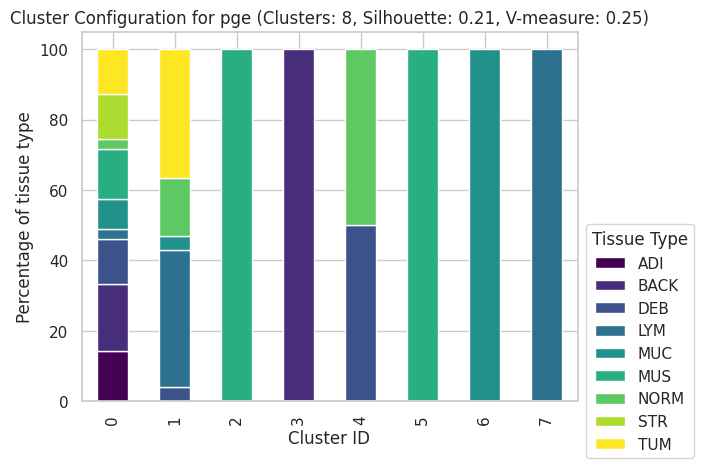

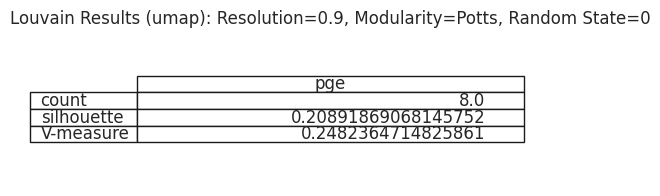

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.29075756669044495
V-measure Score: 0.25954926444612303

Modularity: Newman
Cluster Size: 3
Silhouette Score: 0.24667534232139587
V-measure Score: 0.27014040821915536

Modularity: Potts
Cluster Size: 8
Silhouette Score: 0.20891869068145752
V-measure Score: 0.2482364714825861



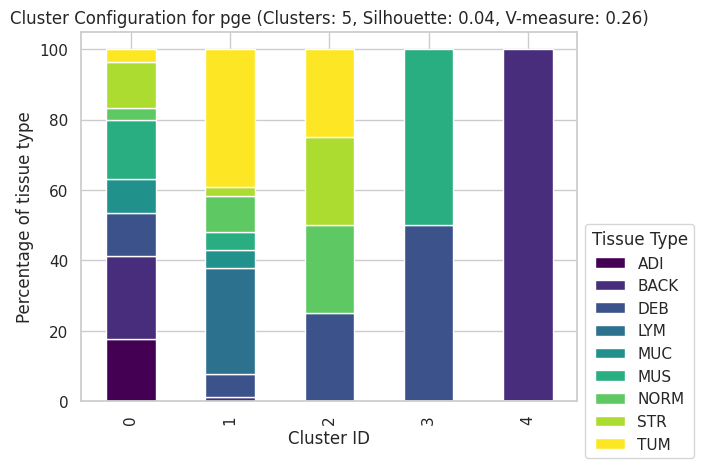

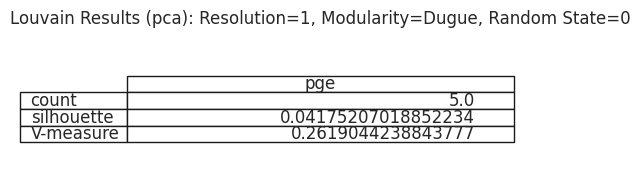

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 5
Silhouette Score: 0.04175207018852234
V-measure Score: 0.2619044238843777

Modularity: Newman
Error in: (pca): Resolution=1, Modularity=Newman, Random State=0
list index out of range


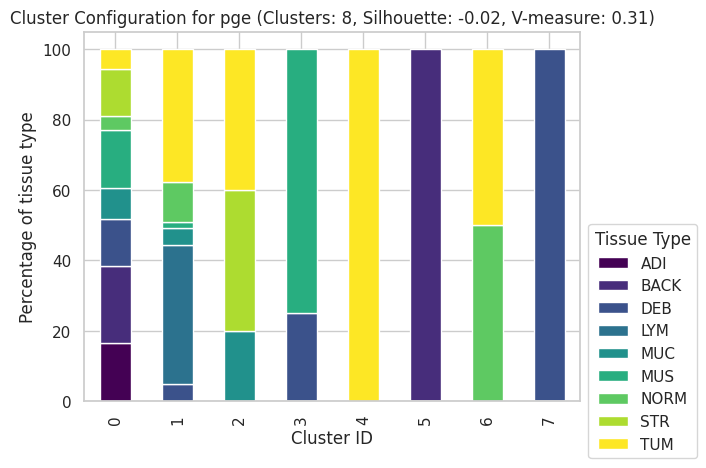

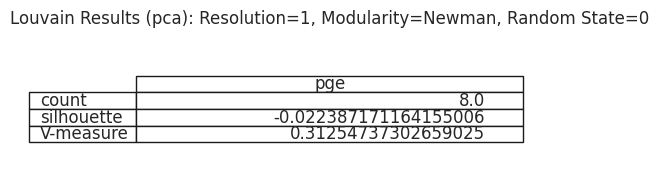

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 5
Silhouette Score: 0.04175207018852234
V-measure Score: 0.2619044238843777

Modularity: Newman
Cluster Size: 8
Silhouette Score: -0.022387171164155006
V-measure Score: 0.31254737302659025

Modularity: Potts
Error in: (pca): Resolution=1, Modularity=Potts, Random State=0
list index out of range


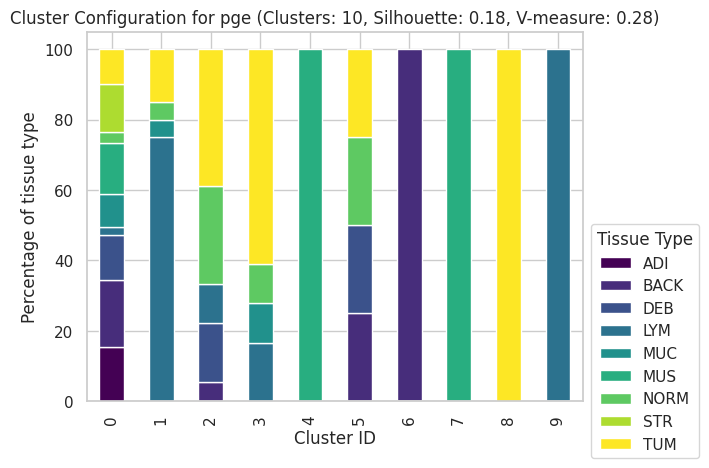

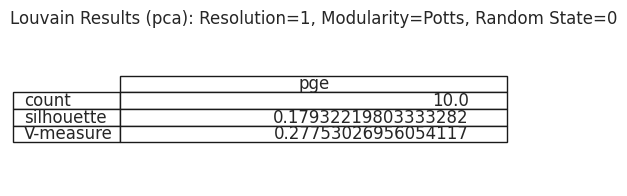

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 5
Silhouette Score: 0.04175207018852234
V-measure Score: 0.2619044238843777

Modularity: Newman
Cluster Size: 8
Silhouette Score: -0.022387171164155006
V-measure Score: 0.31254737302659025

Modularity: Potts
Cluster Size: 10
Silhouette Score: 0.17932219803333282
V-measure Score: 0.27753026956054117



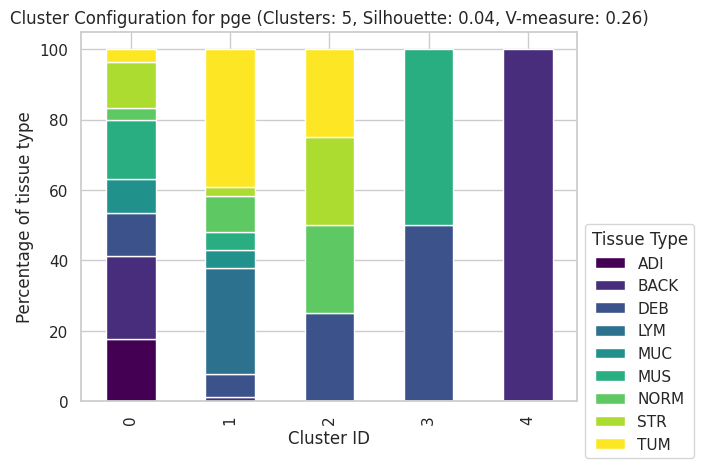

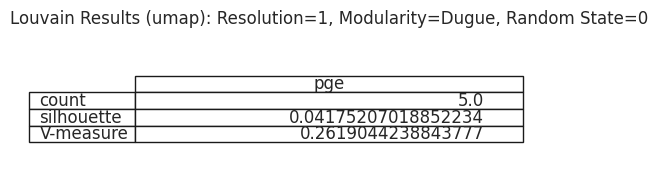

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 5
Silhouette Score: 0.04175207018852234
V-measure Score: 0.2619044238843777

Modularity: Newman
Error in: (umap): Resolution=1, Modularity=Newman, Random State=0
list index out of range


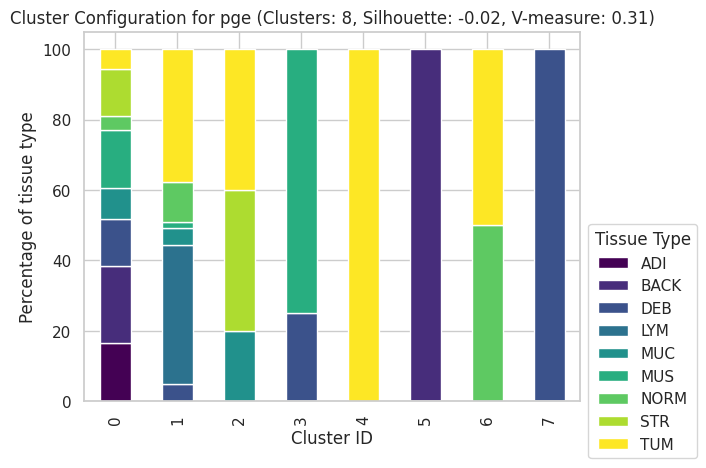

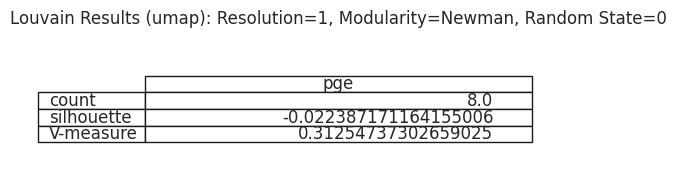

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 5
Silhouette Score: 0.04175207018852234
V-measure Score: 0.2619044238843777

Modularity: Newman
Cluster Size: 8
Silhouette Score: -0.022387171164155006
V-measure Score: 0.31254737302659025

Modularity: Potts
Error in: (umap): Resolution=1, Modularity=Potts, Random State=0
list index out of range


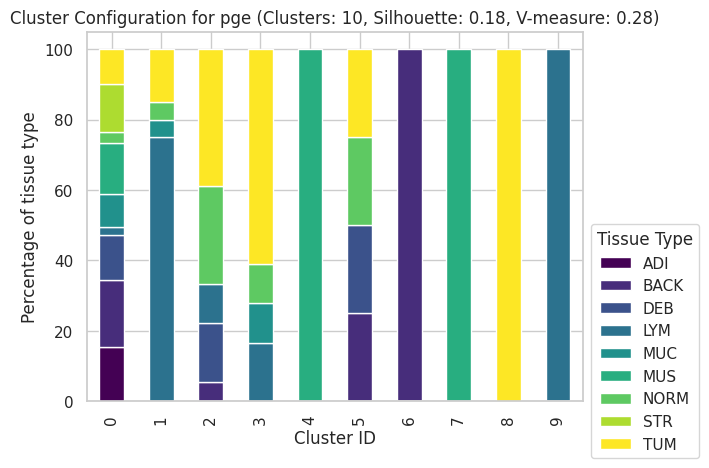

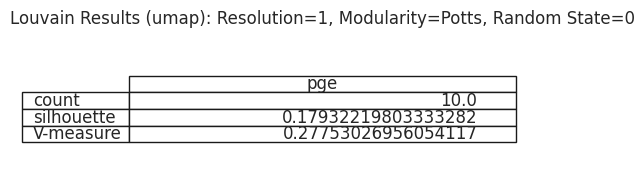

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 5
Silhouette Score: 0.04175207018852234
V-measure Score: 0.2619044238843777

Modularity: Newman
Cluster Size: 8
Silhouette Score: -0.022387171164155006
V-measure Score: 0.31254737302659025

Modularity: Potts
Cluster Size: 10
Silhouette Score: 0.17932219803333282
V-measure Score: 0.27753026956054117



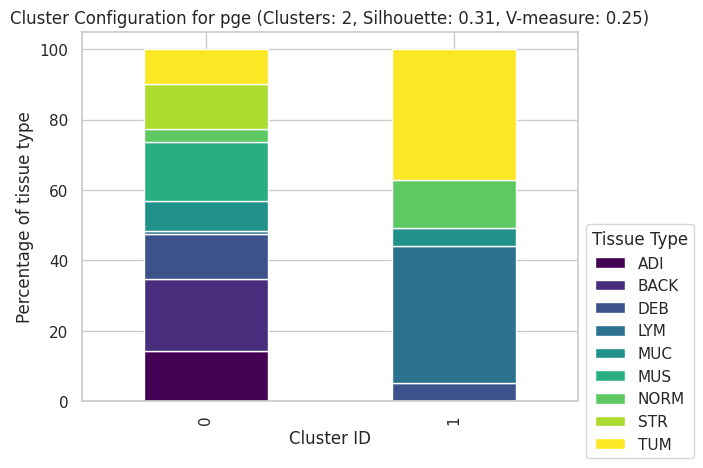

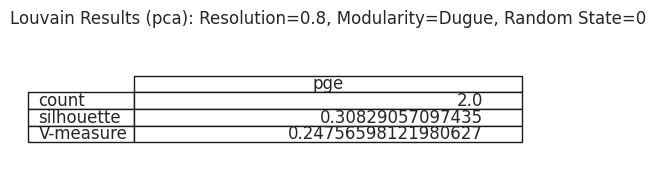

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.30829057097435
V-measure Score: 0.24756598121980627

Modularity: Newman
Error in: (pca): Resolution=0.8, Modularity=Newman, Random State=0
list index out of range


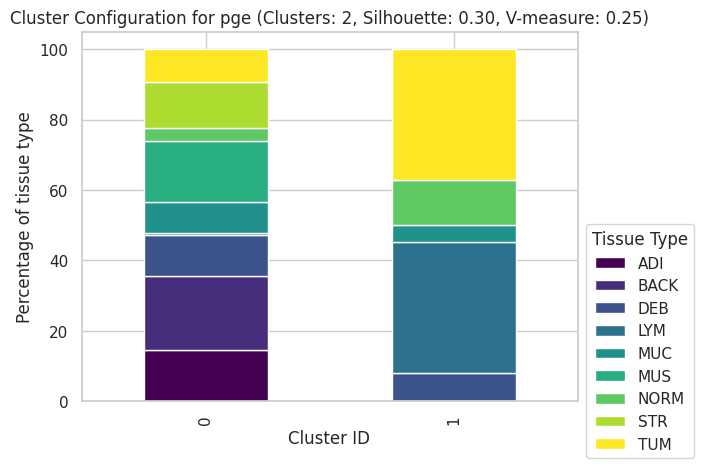

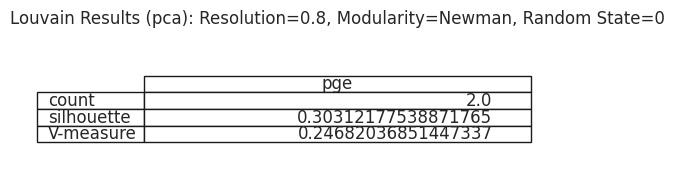

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.30829057097435
V-measure Score: 0.24756598121980627

Modularity: Newman
Cluster Size: 2
Silhouette Score: 0.30312177538871765
V-measure Score: 0.24682036851447337

Modularity: Potts
Error in: (pca): Resolution=0.8, Modularity=Potts, Random State=0
list index out of range


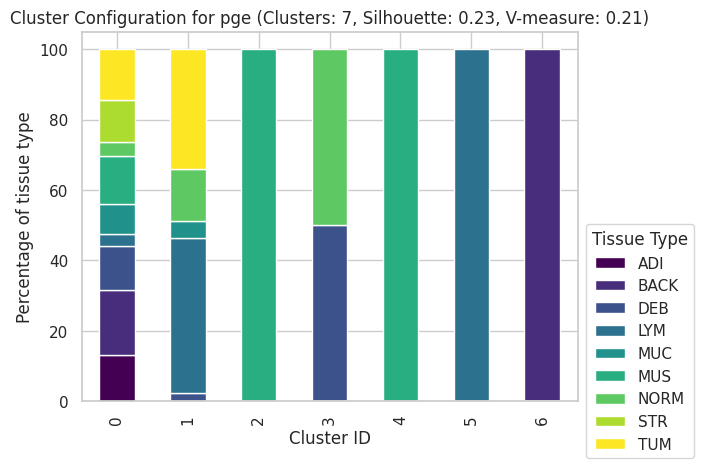

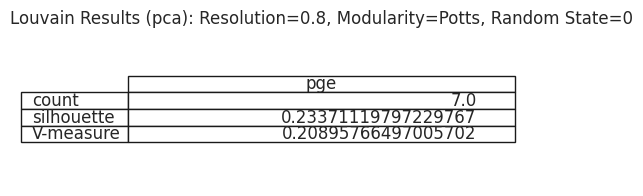

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.30829057097435
V-measure Score: 0.24756598121980627

Modularity: Newman
Cluster Size: 2
Silhouette Score: 0.30312177538871765
V-measure Score: 0.24682036851447337

Modularity: Potts
Cluster Size: 7
Silhouette Score: 0.23371119797229767
V-measure Score: 0.20895766497005702



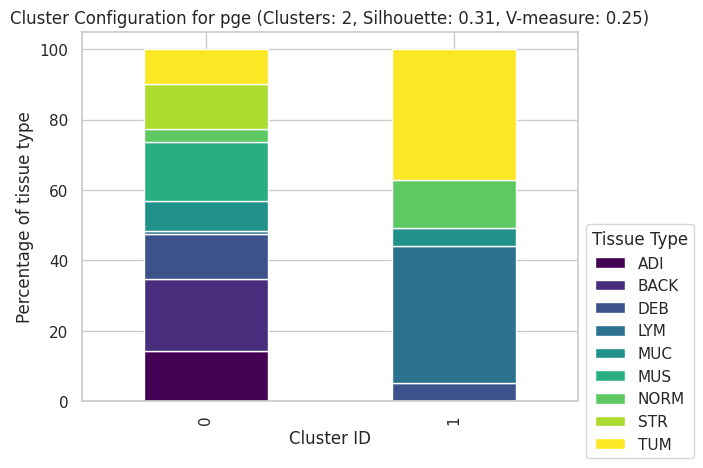

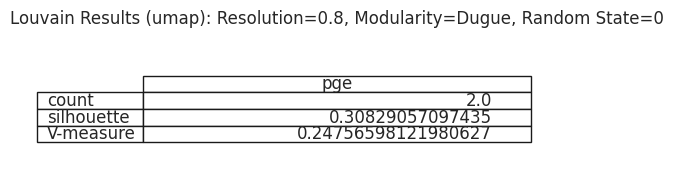

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.30829057097435
V-measure Score: 0.24756598121980627

Modularity: Newman
Error in: (umap): Resolution=0.8, Modularity=Newman, Random State=0
list index out of range


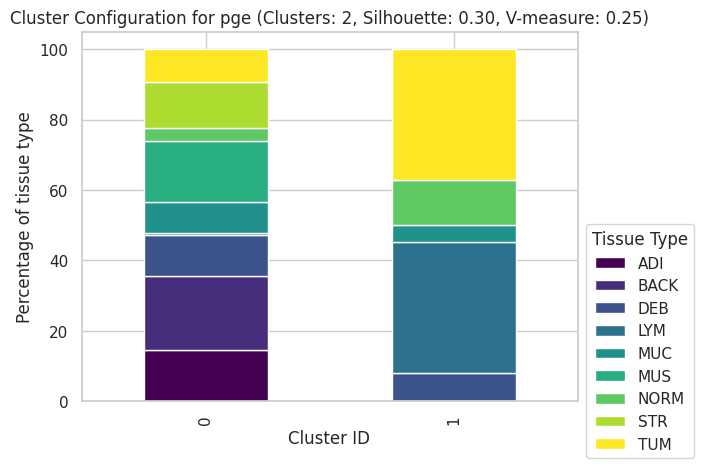

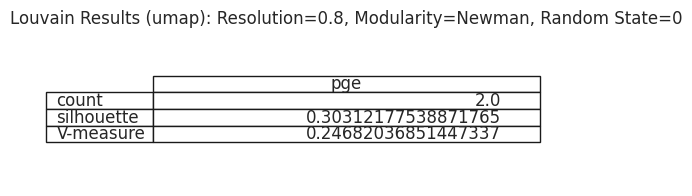

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.30829057097435
V-measure Score: 0.24756598121980627

Modularity: Newman
Cluster Size: 2
Silhouette Score: 0.30312177538871765
V-measure Score: 0.24682036851447337

Modularity: Potts
Error in: (umap): Resolution=0.8, Modularity=Potts, Random State=0
list index out of range


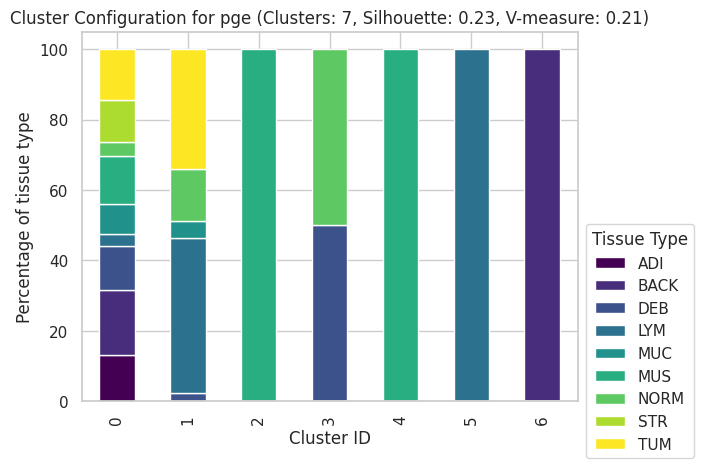

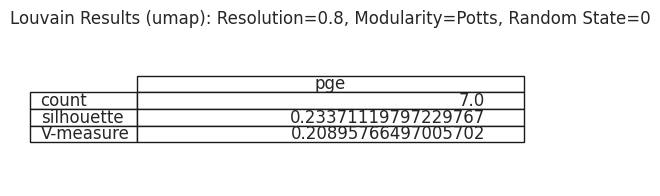

Evaluation Metrics Results:
Modularity: Dugue
Cluster Size: 2
Silhouette Score: 0.30829057097435
V-measure Score: 0.24756598121980627

Modularity: Newman
Cluster Size: 2
Silhouette Score: 0.30312177538871765
V-measure Score: 0.24682036851447337

Modularity: Potts
Cluster Size: 7
Silhouette Score: 0.23371119797229767
V-measure Score: 0.20895766497005702


Best Number of Clusters for Each Representation:
Representation: pge, Best Cluster Size: 10, Scores: (0.1793222, 0.27753026956054117)


/tmp/ipykernel_6581/710257128.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_subset.sort_values(by=['configuration', 'cluster_size'], inplace=True)
/tmp/ipykernel_6581/710257128.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_subset.sort_values(by=['configuration', 'cluster_size'], inplace=True)
/tmp/ipykernel_6581/710257128.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_subset.sort_values(by=['configura

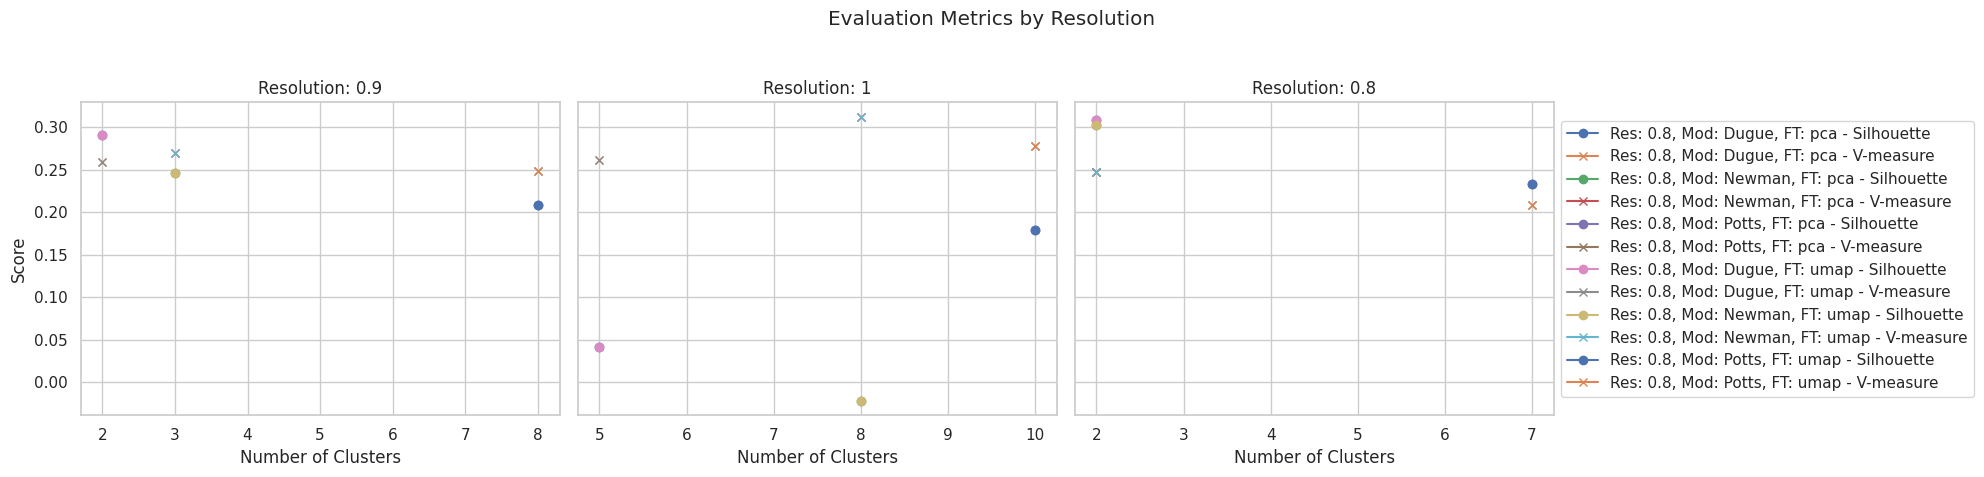

In [28]:
# Pick the representation
print(f"Available representations: {representations}")
representation = input("Enter the representation: ")
if representation not in representations:
    raise ValueError("Invalid representation")
else:
    print("The choosen representation is: ", representation)

# Initialize structures to store results
all_results = {
    'configuration': [],
    'cluster_size': [],
    'silhouette_score': [],
    'v_measure_score': []
}

# Constants
resolutions = [0.9, 1, 0.8]

# Prepare a dictionary to hold the results grouped by resolution
grouped_results = {res: [] for res in resolutions}


# Main Script for Louvain Clustering
for resolution in [0.9, 1, 0.8]:
    for feature_type in feature_types:
        scores_silhouette.clear()
        scores_v_measure.clear()
        cluster.clear()
        for modularity in modularity_options:
            try:
                # Get Data
                dataset = datasets[representation][feature_type]

                # Get Testing Data
                filename = np.squeeze(data_content[representation]['file_name'])
                filename = np.array([str(x) for x in filename])
                labels = np.array([x.split('/')[2] for x in filename])
                random.seed(0)
                selected_index = random.sample(list(np.arange(len(dataset))), 200)
                test_data = dataset[selected_index]
                test_label = labels[selected_index]

                # Apply Louvain
                louvain_model = Louvain(resolution=resolution, modularity=modularity, random_state=random_state)
                adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
                louvain_assignment = louvain_model.fit_transform(adjacency_matrix)
                labels = louvain_model.fit_predict(adjacency_matrix)

                # Evaluation Metrics
                counts = np.unique(labels, return_counts=True)
                cluster_size = counts[0].size
                silhouette = silhouette_score(test_data, labels)
                v_measure = v_measure_score(test_label, labels)
                
                # Update best cluster size and scores
                if representation not in best_cluster_sizes:
                    best_cluster_sizes[representation] = cluster_size
                    best_scores[representation] = (silhouette, v_measure)
                else:
                    if cluster_size > best_cluster_sizes[representation]:
                        best_cluster_sizes[representation] = cluster_size
                        best_scores[representation] = (silhouette, v_measure)
                
                cluster.append(cluster_size)
                scores_silhouette.append(silhouette)
                scores_v_measure.append(v_measure)

                # Evaluation Metrics Results
                louvain_results = [int(counts[0].size),
                                silhouette_score(test_data, labels),
                                v_measure_score(test_label, labels)]
                
                label_proportion = pd.DataFrame({'clusterID': labels, 'type': test_label})
                label_proportion = label_proportion.groupby(['clusterID']).apply(lambda x: x['type'].value_counts(normalize=True)).unstack().fillna(0) * 100
                label_proportion.plot(kind='bar', stacked=True, colormap='viridis')
                sns.set(style="whitegrid")
                plt.title(f'Cluster Configuration for {representation} (Clusters: {cluster_size}, Silhouette: {silhouette:.2f}, V-measure: {v_measure:.2f})')
                plt.xlabel('Cluster ID')
                plt.ylabel('Percentage of tissue type')
                plt.legend(title='Tissue Type', loc='upper right', bbox_to_anchor=(1.25, 0.5))
                plt.show()
                
                louvain_results_dictionary = results_headers.copy()
                louvain_results_dictionary.update({representation: louvain_results})
                frame = pd.DataFrame(louvain_results_dictionary).set_index('Metrics')
                fig = plt.figure(figsize=(5, 2))
                ax = fig.add_subplot(111)
                ax.table(cellText=frame.values, rowLabels=frame.index, colLabels=frame.columns, loc="center")
                ax.set_title(f"Louvain Results ({feature_type}): Resolution={resolution}, Modularity={modularity}, Random State={random_state}")
                ax.axis("off")
                plt.show()

                # Raw Data Output
                print("Evaluation Metrics Results:")
                for i, modularity in enumerate(modularity_options):
                    print(f"Modularity: {modularity}")
                    print(f"Cluster Size: {cluster[i]}")
                    print(f"Silhouette Score: {scores_silhouette[i]}")
                    print(f"V-measure Score: {scores_v_measure[i]}")
                    print()

                
                # Store results for each configuration
                for i, modularity in enumerate(modularity_options):
                    config_name = f"Res: {resolution}, Mod: {modularity}, FT: {feature_type}"
                    all_results['configuration'].append(config_name)
                    all_results['cluster_size'].append(cluster[i])
                    all_results['silhouette_score'].append(scores_silhouette[i])
                    all_results['v_measure_score'].append(scores_v_measure[i])
            except Exception as e:
                print(f"Error in: ({feature_type}): Resolution={resolution}, Modularity={modularity}, Random State={random_state}")
                print(e)

# Print the best number of clusters for each representation
print("\nBest Number of Clusters for Each Representation:")
for rep in best_cluster_sizes:
    print(f"Representation: {rep}, Best Cluster Size: {best_cluster_sizes[rep]}, Scores: {best_scores[rep]}")

# Now, transform the 'all_results' dictionary into a DataFrame and group by resolution
results_df = pd.DataFrame(all_results)

# Create subplots - one for each resolution
fig, axes = plt.subplots(nrows=1, ncols=len(resolutions), figsize=(20, 5), sharey=True)

for ax, resolution in zip(axes.flatten(), resolutions):
    res_subset = results_df[results_df['configuration'].str.contains(f"Res: {resolution}")]
    res_subset.sort_values(by=['configuration', 'cluster_size'], inplace=True)
    
    # Plot lines for each feature type and modularity within the current resolution
    for feature_type in feature_types:
        for modularity in modularity_options:
            config_name = f"Res: {resolution}, Mod: {modularity}, FT: {feature_type}"
            subset = res_subset[res_subset['configuration'] == config_name]
            ax.plot(subset['cluster_size'], subset['silhouette_score'], '-o', label=f'{config_name} - Silhouette')
            ax.plot(subset['cluster_size'], subset['v_measure_score'], '-x', label=f'{config_name} - V-measure')

    
    # Set titles and labels
    ax.set_title(f'Resolution: {resolution}')
    ax.set_xlabel('Number of Clusters')
    if ax is axes[0]:  # Only add y label to the first subplot to avoid repetition
        ax.set_ylabel('Score')

# Create an overall title
plt.suptitle('Evaluation Metrics by Resolution')

# Move the legend to the right of the subplots
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Ensure the layout is tight so labels don't overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

In [29]:
cluster

[2, 2, 7]

pca at 0.9          2, 3, 8
umap at 0.9         2, 3 ,8
pca at 1            5 , 8, 10
umap at 1           5, 8, 10
pca at 0.8          2, 2, 7
umap at 0.8         2, 2, 7


In [30]:
scores_silhouette

[0.30829057, 0.30312178, 0.2337112]

In [31]:
results_df.to_csv('results_df.csv', index=False)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, pairwise_distances, v_measure_score
from sknetwork.clustering import Louvain
from scipy import sparse
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load Data Content
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')

#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

# Load and normalize the PCA features
# Assuming pge_features['pca_feature'] contains the PCA features from the 'pge' dataset
scaler = MinMaxScaler()
pge_normalized = scaler.fit_transform(pge_content['pca_feature'][...])

# Parameters for Louvain clustering
resolutions = [0.9, 1, 0.8]
modularity_options = ['Dugue', 'Newman', 'Potts']
random_state = 0

# Initialize results storage
louvain_results = []

# Louvain Clustering
for resolution in resolutions:
    for modularity in modularity_options:
        louvain_model = Louvain(resolution=resolution, modularity=modularity, random_state=random_state)
        adjacency_matrix = sparse.csr_matrix(-pairwise_distances(pge_normalized))
        labels = louvain_model.fit_predict(adjacency_matrix)

        # Evaluation Metrics (using Silhouette Score)
        silhouette = silhouette_score(pge_normalized, labels)

        # Store results
        louvain_results.append({
            'resolution': resolution,
            'modularity': modularity,
            'silhouette_score': silhouette,
            'cluster_size': len(np.unique(labels))
        })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(louvain_results)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='cluster_size', y='silhouette_score', hue='resolution', style='modularity', markers=True)
plt.title('Louvain Clustering Performance')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend(title='Resolution and Modularity')
plt.show()

# Summary of Best Configurations
best_configurations = results_df.sort_values(by='silhouette_score', ascending=False).groupby(['resolution', 'modularity']).first().reset_index()
print("Best Configurations by Resolution and Modularity:")
print(best_configurations[['resolution', 'modularity', 'cluster_size', 'silhouette_score']])
